In [178]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
import scipy.optimize._minimize as minimize

In [179]:
#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
%matplotlib inline


# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.4, 'center_x': 270, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
x_grid, y_grid = np.meshgrid(np.linspace(0, size, size+1), np.linspace(0, size, size+1))
# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape) #(y,x)
alpha_y_2d = alpha_y.reshape(x_grid.shape) #(y,x)





In [ ]:
'''# real point source
coord = (305.5,345.4)
coord_x_r = coord[0]%1
coord_y_r = coord[1]%1
coordinates = []
n=0
if coord_x_r != 0.5 and coord_y_r != 0.5:
    for i in range(size):
        for j in range(size):
            ycoord = i-alpha_y_2d[i,j] # src coord
            xcoord = j-alpha_x_2d[i,j]
            if round(ycoord) == round(coord[1]) and round(xcoord) == round(coord[0]):
                coordinates.append((j,i)) #(x,y)
                n+=1

if coord_x_r == 0.5 and coord_y_r != 0.5:
    for i in range(size):
        for j in range(size):
            ycoord = i-alpha_y_2d[i,j] # src coord
            xcoord = j-alpha_x_2d[i,j]
            x_round = round(coord[0])
            if round(ycoord) == round(coord[1]) and (round(xcoord) == x_round or round(xcoord) == x_round-1):
                coordinates.append((j,i)) #(x,y)
                n+=1

if coord_x_r != 0.5 and coord_y_r == 0.5:
    for i in range(size):
        for j in range(size):
            ycoord = i-alpha_y_2d[i,j] # src coord
            xcoord = j-alpha_x_2d[i,j]
            y_round = round(coord[1])
            if (round(ycoord) == y_round or round(ycoord) == y_round-1) and round(xcoord) == round(coord[0]):
                coordinates.append((j,i)) #(x,y)
                n+=1

if coord_x_r == 0.5 and coord_y_r == 0.5:
    for i in range(size):
        for j in range(size):
            ycoord = i-alpha_y_2d[i,j] # src coord
            xcoord = j-alpha_x_2d[i,j]
            y_round = round(coord[1])
            x_round = round(coord[0])
            if (round(ycoord) == y_round or round(ycoord) == y_round-1) and (round(xcoord) == x_round or round(xcoord) == x_round-1):
                coordinates.append((j,i)) #(x,y)
                n+=1


plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=1)
plt.scatter(coord[0], coord[1], c='b', s=1)
print(n)
alpha_x, alpha_y = lensModel.alpha(242.58012158, 282.54607038, kwargs_lens)
print(242.58012158-alpha_x, 282.54607038-alpha_y)   '''

32


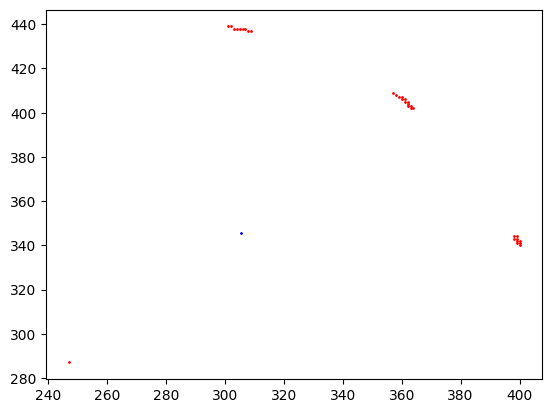

In [192]:
# Assuming alpha_y_2d and alpha_x_2d are defined and 'size' is known
coord = (305.5,345.4)
coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
y_round, x_round = round(coord[1]), round(coord[0])

# Pre-calculate possible matching rounded values for efficiency
y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

coordinates = []
n = 0

# Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
for i in range(size):
    for j in range(size):
        ycoord, xcoord = i - alpha_y_2d[i, j], j - alpha_x_2d[i, j]
        if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
            coordinates.append((j, i))  # (x, y)
            n += 1

plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=1)
plt.scatter(coord[0], coord[1], c='b', s=1)
print(n)

Number of pixels: [1, 9, 13, 9]


(150.0, 450.0)

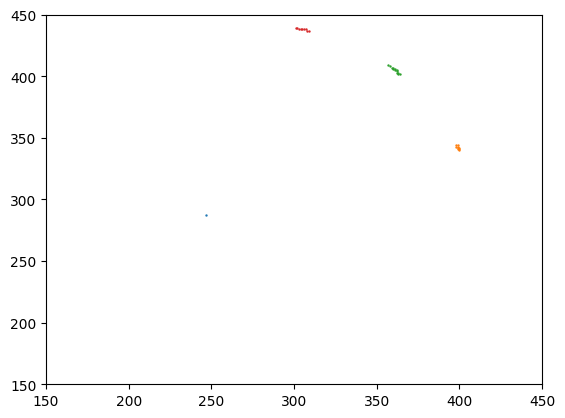

In [187]:
#magnification
from sklearn.cluster import DBSCAN

coordinates = np.array(coordinates)

# Apply DBSCAN clustering
# eps and min_samples need to be chosen based on your specific data
dbscan = DBSCAN(eps=6, min_samples=1).fit(coordinates)

# Extract labels
labels = dbscan.labels_

# Separate coordinates into arrays for each image
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]

# images now contains separate arrays for each detected image
# convert the dictionary images to list
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=0.5)

'''m=[]
for i in range(0, len(images)):
    mag = len(images[i])/len(circle_coords)
    m.append(mag)
print(f'Magnification: {m}')'''
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')
plt.xlim(150,450)
plt.ylim(150,450)


In [188]:
# src or img pos?
def src_pos_test(img_guess, lensModel=lensModel):
    alpha_x, alpha_y = lensModel.alpha(img_guess[0], img_guess[1], kwargs_lens)
    return (img_guess[0]-alpha_x, img_guess[1]-alpha_y) #src guess
def diff (img_guess):
    return np.sqrt((src_pos_test(img_guess)[0]-coord[0])**2 + (src_pos_test(img_guess)[1]-coord[1])**2)

247 247 287 287 [247.6500578  287.67612935] 1.9414823959851246e-08
398 400 340 344 [398.73823293 343.94366999] 3.321552048933995e-09
357 364 402 409 [362.92077517 403.55183742] 7.483046144568326e-09
301 309 437 439 [304.48456708 438.52095799] 1.0131157540747531e-08


"from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver\n\n# specifiy the lens model class to deal with #\nsolver = LensEquationSolver(lensModel)\n\n# solve for image positions provided a lens model and the source position #\nimg_x, img_y = solver.image_position_analytical(coord[0],coord[1], kwargs_lens)\nprint(img_x, img_y)\nplt.scatter(img_x, img_y, c='r', s=100, marker='x')"

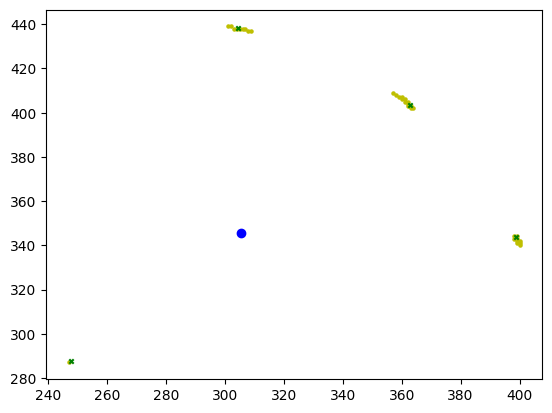

In [193]:
# minimum distance between the source position and the guess source positions deflected by mutiple images
# expect partition of the images and search for 1 sol for 1 image
plt.scatter(coord[0], coord[1], c='b')
plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='y', s=5)
# find maximum x and y coordinates of the image[i]
for i in range(len(images)):
    x_max, x_min = np.max(images[i][:,0]), np.min(images[i][:,0])
    y_max, y_min = np.max(images[i][:,1]), np.min(images[i][:,1])
    img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
    pos = minimize.minimize(diff, img_guess, bounds =[(x_min-1, x_max+1), (y_min-1, y_max+1)], method='L-BFGS-B', tol=1e-8) # the 1 is for wider boundary
    print(x_min, x_max, y_min, y_max, pos.x, diff(pos.x))
    plt.scatter(pos.x[0], pos.x[1], c='g', s=10, marker='x')


'''from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
img_x, img_y = solver.image_position_analytical(coord[0],coord[1], kwargs_lens)
print(img_x, img_y)
plt.scatter(img_x, img_y, c='r', s=100, marker='x')'''


[(396, 328), (395, 329), (395, 330), (395, 331), (361, 395), (360, 396), (361, 396), (360, 397), (284, 437), (285, 437), (286, 437)]
[(242, 282), (396, 324), (396, 325), (396, 326), (396, 327), (358, 397), (359, 397), (357, 398), (358, 398), (357, 399), (284, 436), (285, 436), (286, 436), (287, 436)]


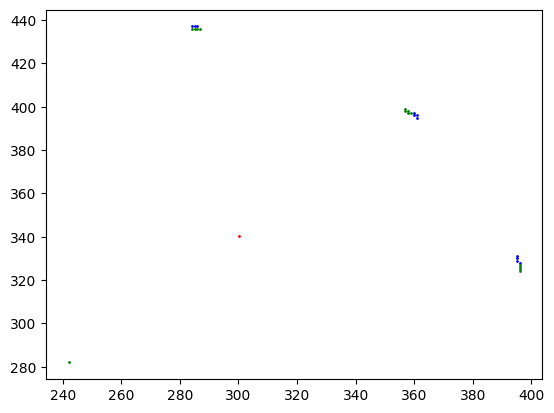

In [173]:
# make a point source
coord = coord

# touch 2 pixels case
nbh_ceil = (coord[0], ceil(coord[1]))
nbh_floor = (coord[0], floor(coord[1]))

img_int_up = []
img_int_down = []


for i in range(size):
    for j in range(size):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        if round(ycoord) == round(nbh_ceil[1]) and round(xcoord) == round(nbh_ceil[0]):
            img_int_up.append((j,i)) #(x,y)
        if round(ycoord) == round(nbh_floor[1]) and round(xcoord) == round(nbh_floor[0]):
            img_int_down.append((j,i))
        


plt.scatter(coord[0], coord[1], c='r', s=1)
plt.scatter([i[0] for i in img_int_up], [i[1] for i in img_int_up], c='b', s=1)
plt.scatter([i[0] for i in img_int_down], [i[1] for i in img_int_down], c='g', s=1)
print(img_int_up)
print(img_int_down)

In [ ]:
# Assuming alpha_y_2d and alpha_x_2d are defined and 'size' is known
coord = (305.5,345.4)
coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
y_round, x_round = round(coord[1]), round(coord[0])

# Pre-calculate possible matching rounded values for efficiency
y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

coordinates = []
n = 0

# Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
for i in range(size):
    for j in range(size):
        ycoord, xcoord = i - alpha_y_2d[i, j], j - alpha_x_2d[i, j]
        if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
            coordinates.append((j, i))  # (x, y)
            n += 1

plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=1)
plt.scatter(coord[0], coord[1], c='b', s=1)

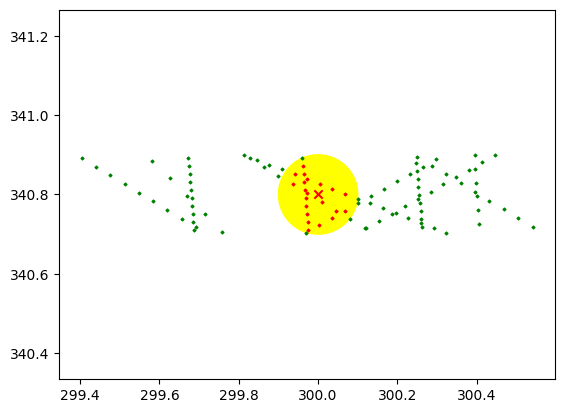

In [165]:
# Number of steps for interpolation
num_steps = 50
n=0
# Function to interpolate between two points

# Function to interpolate deflection angles
def interpolate_deflection(p1, p2, num_steps, alpha_y_2d):
    deflection_steps = []
    for t in range(num_steps + 1):
        ratio = t / num_steps
        y = p1[1] + (p2[1] - p1[1]) * ratio
        x = p1[0] + (p2[0] - p1[0]) * ratio
        alpha_x = alpha_x_2d[p1[1],p1[0]]*ratio + alpha_x_2d[p2[1],p2[0]]*(1-ratio)
        alpha_y = alpha_y_2d[p1[1],p1[0]]*ratio + alpha_y_2d[p2[1],p2[0]]*(1-ratio)
        src_y = y-alpha_y
        src_x = x-alpha_x
        deflection_steps.append([x, y, src_x, src_y])
    return deflection_steps

points = []

# Generate steps for each pair of points
for i in range(len(img_int_up)):
    for j in range(len(img_int_down)):
        up = img_int_up[i]
        down = img_int_down[j]
        if abs(up[0]-down[0])>1 or abs(up[1]-down[1])>1:
            continue
        if up[0] == down[0] and up[1] == down[1]:
            continue
        # Get img pos and src y coord 
        src_pos = interpolate_deflection(up, down, num_steps, alpha_y_2d)
    
        for k in range(len(src_pos)):
            dy = abs(src_pos[k][3] - center[1])
            if dy<radius:
                points.append(src_pos[k])

from matplotlib.patches import Circle
circle = Circle(center, radius, color='yellow', fill=True)
ax = plt.gca()  # Get current axes
ax.add_patch(circle)  # Add the circle to the plot
plt.scatter(center[0], center[1], c='r', marker='x')
plt.axis('equal')  # Set equal scaling by changing axis limits

for i in range(len(points)):
    dist = np.sqrt((points[i][2]-center[0])**2 + (points[i][3]-center[1])**2)
    if dist < radius:
        plt.scatter(points[i][2], points[i][3], c='r', s=2, marker='D')
    else:
        plt.scatter(points[i][2], points[i][3], c='g', s=2, marker='D')

Interpolation algo trials

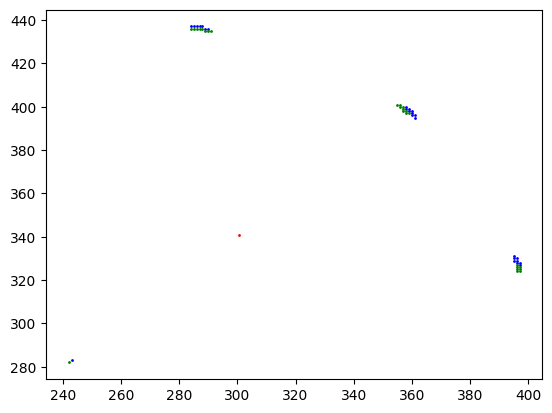

In [89]:
# trying 2d interpolation

# make a subpixel circle
center = (300.45, 340.8)
radius = 0.1

# locate the source plane pixel that the center of the circle is in
nbh_ceil_r = (ceil(center[0]), ceil(center[1]))
nbh_ceil_l = (floor(center[0]), ceil(center[1]))
nbh_floor_r = (ceil(center[0]), floor(center[1]))
nbh_floor_l = (floor(center[0]), floor(center[1]))
img_int_up_r = []
img_int_up_l = []
img_int_down_r = []
img_int_down_l = []

for i in range(size):
    for j in range(size):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        if round(ycoord) == nbh_ceil_r[1] and round(xcoord) == nbh_ceil_r[0]:
            img_int_up_r.append((j,i)) #(x,y)
        if round(ycoord) == nbh_ceil_l[1] and round(xcoord) == nbh_ceil_l[0]:
            img_int_up_l.append((j,i))
        if round(ycoord) == nbh_floor_r[1] and round(xcoord) == nbh_floor_r[0]:
            img_int_down_r.append((j,i))
        if round(ycoord) == nbh_floor_l[1] and round(xcoord) == nbh_floor_l[0]:
            img_int_down_l.append((j,i)) #(x,y)


plt.scatter(center[0], center[1], c='r', s=1)
plt.scatter([i[0] for i in img_int_up_r], [i[1] for i in img_int_up_r], c='b', s=1)
plt.scatter([i[0] for i in img_int_up_l], [i[1] for i in img_int_up_l], c='b', s=1)
plt.scatter([i[0] for i in img_int_down_r], [i[1] for i in img_int_down_r], c='g', s=1)
plt.scatter([i[0] for i in img_int_down_l], [i[1] for i in img_int_down_l], c='g', s=1)


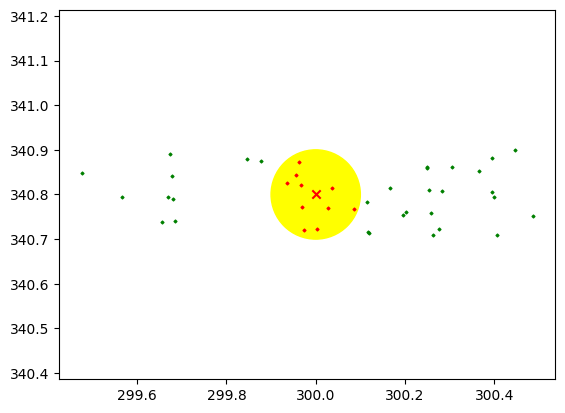

In [105]:

# Number of steps for interpolation
num_steps = 20
n=0
# Function to interpolate between two points

# Function to interpolate deflection angles
def interpolate_deflection(p1, p2, num_steps, alpha_y_2d):
    deflection_steps = []
    for t in range(num_steps + 1):
        ratio = t / num_steps
        y = p1[1] + (p2[1] - p1[1]) * ratio
        x = p1[0] + (p2[0] - p1[0]) * ratio
        alpha_x = alpha_x_2d[p1[1],p1[0]]*ratio + alpha_x_2d[p2[1],p2[0]]*(1-ratio)
        alpha_y = alpha_y_2d[p1[1],p1[0]]*ratio + alpha_y_2d[p2[1],p2[0]]*(1-ratio)
        src_y = y-alpha_y
        src_x = x-alpha_x
        deflection_steps.append([x, y, src_x, src_y])
    return deflection_steps

points = []

# Generate steps for each pair of points
for i in range(len(img_int_up)):
    for j in range(len(img_int_down)):
       
        up = img_int_up[i]
        down = img_int_down[j]
        if abs(up[0]-down[0])>1 or abs(up[1]-down[1])>1:
            continue
        if up[0] == down[0] and up[1] == down[1]:
            continue
        # Get img pos and src y coord 
        src_pos = interpolate_deflection(up, down, num_steps, alpha_y_2d)
    
        for k in range(len(src_pos)):
            dy = abs(src_pos[k][3] - center[1])
            if dy<radius:
                points.append(src_pos[k])

from matplotlib.patches import Circle
circle = Circle(center, radius, color='yellow', fill=True)
ax = plt.gca()  # Get current axes
ax.add_patch(circle)  # Add the circle to the plot
plt.scatter(center[0], center[1], c='r', marker='x')
plt.axis('equal')  # Set equal scaling by changing axis limits

for i in range(len(points)):
    dist = np.sqrt((points[i][2]-center[0])**2 + (points[i][3]-center[1])**2)
    if dist < radius:
        plt.scatter(points[i][2], points[i][3], c='r', s=2, marker='D')
    else:
        plt.scatter(points[i][2], points[i][3], c='g', s=2, marker='D')
    
            
